# Αναγνώριση Προτύπων - Μηχανική Μάθηση Εργασία 2η

Αλατζάς Αλέξανδρος - 1115201900005

# **Ερώτημα 1: Feedforward Neural Network**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## *Βήμα 1: Φόρτωση δεδομένων mfccs*

In [2]:
# Dataset paths
train_X_path = '/content/drive/My Drive/ML_2024/data/music_genre_data_di/train/mfccs/X.npy'
train_labels_path = '/content/drive/My Drive/ML_2024/data/music_genre_data_di/train/mfccs/labels.npy'
val_X_path = '/content/drive/My Drive/ML_2024/data/music_genre_data_di/val/mfccs/X.npy'
val_labels_path = '/content/drive/My Drive/ML_2024/data/music_genre_data_di/val/mfccs/labels.npy'
test_X_path = '/content/drive/My Drive/ML_2024/data/music_genre_data_di/test/mfccs/X.npy'
test_labels_path = '/content/drive/My Drive/ML_2024/data/music_genre_data_di/test/mfccs/labels.npy'

In [3]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import time

In [4]:
# Load data from paths
X_train = np.load(train_X_path)
y_train = np.load(train_labels_path)

X_val = np.load(val_X_path)
y_val = np.load(val_labels_path)

X_test = np.load(test_X_path)
y_test = np.load(test_labels_path)

# Mapping unique classes to integers
labels = np.unique(y_train)
labels_dict = {lb: id for id, lb in enumerate(labels)}
y_train = np.array([labels_dict[label] for label in y_train])
y_val = np.array([labels_dict[label] for label in y_val])
y_test = np.array([labels_dict[label] for label in y_test])

# Load data on PyTorch dataloaders
train_dataset = TensorDataset(torch.from_numpy(X_train.astype(np.float32)), torch.from_numpy(y_train))
val_dataset = TensorDataset(torch.from_numpy(X_val.astype(np.float32)), torch.from_numpy(y_val))
test_dataset = TensorDataset(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test))

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

## *Βήμα 2: Ορισμός Νευρωνικού Δικτύου*

In [5]:
class FullyConnectedNeuralNetwork(nn.Module):
    def __init__(self):
        super(FullyConnectedNeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(26, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 4)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x

# Set device as cpu
device = 'cpu'

## *Βήμα 3: Ορισμός διαδικασίας εκπαίδευσης*

In [6]:
def train_function(n_epochs, optimizer, dataloader, loss_function, model):
    size = len(dataloader.dataset)
    for epoch in range(n_epochs):
        print(f'Training Epoch: {epoch+1}')

        # For every batch in the dataloader
        for batch, (X, y) in enumerate(dataloader):
            # Move data and labels on the device
            X = X.to(device)
            y = y.to(device)

            # Compute the model predictions and loss
            predictions = model(X)
            loss = loss_function(predictions, y)

            # Zero the gradients before backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step() # Update the model parameters

            # Print every 32 batches
            if batch % 32 == 0:
                loss, current = loss.item(), batch * len(X)
                print(f'loss: {loss:>7f}  [{current:>5d}/{size:>5d}]')

    return model

## *Βήμα 4: Ορισμός διαδικασίας αξιολόγησης*

In [7]:
def evaluation_function(dataloader, loss_function, model):
    size = len(dataloader)
    test_loss = 0

    true_labels = []
    pred_labels = []

    # Disable gradient calculation for evaluation
    with torch.no_grad():
        # For every batch in the dataloader
        for X, y in dataloader:
            # Move data and labels on the device
            X = X.to(device)
            y = y.to(device)

            # Compute the model predictions and loss
            predictions = model(X)
            test_loss += loss_function(predictions, y).item()

            # Get the predicted labels by taking the argmax of the predictions along dimension 1
            pred_labels.extend(predictions.argmax(1).cpu().numpy())

            true_labels.extend(y.cpu().numpy())

    # Compute required metrics
    average_loss = test_loss / size
    f1 = f1_score(true_labels, pred_labels, average='macro')
    accuracy = accuracy_score(true_labels, pred_labels)
    confusion_mx = confusion_matrix(true_labels, pred_labels)

    return average_loss, f1, accuracy, confusion_mx

## *Βήμα 5: Εκπαίδευση δικτύου*

In [8]:
fcnn_model = FullyConnectedNeuralNetwork().to(device)

learning_rate = 0.002
n_epochs = 30
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fcnn_model.parameters(), learning_rate)

# Calculate time elapsed
tik_cpu = time.time()
train_function(n_epochs, optimizer, train_dataloader, loss_function, fcnn_model)
tok_cpu = time.time() - tik_cpu

Training Epoch: 1
loss: 1.590100  [    0/ 3200]
loss: 1.365540  [  512/ 3200]
loss: 1.413028  [ 1024/ 3200]
loss: 1.432927  [ 1536/ 3200]
loss: 1.408362  [ 2048/ 3200]
loss: 1.418066  [ 2560/ 3200]
loss: 1.385072  [ 3072/ 3200]
Training Epoch: 2
loss: 1.367388  [    0/ 3200]
loss: 1.388020  [  512/ 3200]
loss: 1.348984  [ 1024/ 3200]
loss: 1.397473  [ 1536/ 3200]
loss: 1.383171  [ 2048/ 3200]
loss: 1.396828  [ 2560/ 3200]
loss: 1.403575  [ 3072/ 3200]
Training Epoch: 3
loss: 1.370492  [    0/ 3200]
loss: 1.401698  [  512/ 3200]
loss: 1.360740  [ 1024/ 3200]
loss: 1.350220  [ 1536/ 3200]
loss: 1.339415  [ 2048/ 3200]
loss: 1.370835  [ 2560/ 3200]
loss: 1.433580  [ 3072/ 3200]
Training Epoch: 4
loss: 1.372223  [    0/ 3200]
loss: 1.308641  [  512/ 3200]
loss: 1.371140  [ 1024/ 3200]
loss: 1.383568  [ 1536/ 3200]
loss: 1.310551  [ 2048/ 3200]
loss: 1.362125  [ 2560/ 3200]
loss: 1.312615  [ 3072/ 3200]
Training Epoch: 5
loss: 1.293515  [    0/ 3200]
loss: 1.232799  [  512/ 3200]
loss: 1.28

In [9]:
average_loss, f1_cpu, accuracy_cpu, confusion_mx_cpu = evaluation_function(test_dataloader, loss_function, fcnn_model)

print(f'{device} training metrics:\n')
print(f'Time elapsed: {tok_cpu}')
print(f'Average Loss: {average_loss}')
print(f'F1 Score (Macro): {f1_cpu}')
print(f'Accuracy: {accuracy_cpu*100} %')
print('Confusion Matrix:')
print(confusion_mx_cpu)

cpu training metrics:

Time elapsed: 9.01183557510376
Average Loss: 0.9429990525335766
F1 Score (Macro): 0.6120586279399634
Accuracy: 62.28197674418605 %
Confusion Matrix:
[[101  33  62 128]
 [ 29 245   6  17]
 [ 76  18 225  37]
 [ 39  38  36 286]]


Μετά την εκπαίδευση του μοντέλου για 30 εποχές, πετυχαίνουμε accuracy 59% και F1 score περίπου 56%.

## *Βήμα 6: Εκπαίδευση δικτύου με GPU*

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

fcnn_model_gpu = FullyConnectedNeuralNetwork().to(device)

learning_rate = 0.002
n_epochs = 30
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fcnn_model_gpu.parameters(), learning_rate)

tik_gpu = time.time()
train_function(n_epochs, optimizer, train_dataloader, loss_function, fcnn_model_gpu)
tok_gpu = time.time() - tik_gpu

average_loss, f1_gpu, accuracy_gpu, confusion_mx_gpu = evaluation_function(test_dataloader, loss_function, fcnn_model_gpu)

print(f'{device} training metrics:\n')
print(f'Time elapsed: {tok_gpu}')
print(f'Average Loss: {average_loss}')
print(f'F1 Score (Macro): {f1_gpu}')
print(f'Accuracy: {accuracy_gpu*100} %')
print('Confusion Matrix:')
print(confusion_mx_gpu)

Training Epoch: 1
loss: 1.520251  [    0/ 3200]
loss: 1.457042  [  512/ 3200]
loss: 1.370317  [ 1024/ 3200]
loss: 1.388909  [ 1536/ 3200]
loss: 1.397867  [ 2048/ 3200]
loss: 1.366295  [ 2560/ 3200]
loss: 1.394967  [ 3072/ 3200]
Training Epoch: 2
loss: 1.327723  [    0/ 3200]
loss: 1.372002  [  512/ 3200]
loss: 1.383395  [ 1024/ 3200]
loss: 1.330730  [ 1536/ 3200]
loss: 1.387114  [ 2048/ 3200]
loss: 1.367107  [ 2560/ 3200]
loss: 1.336890  [ 3072/ 3200]
Training Epoch: 3
loss: 1.306378  [    0/ 3200]
loss: 1.223446  [  512/ 3200]
loss: 1.307796  [ 1024/ 3200]
loss: 1.334255  [ 1536/ 3200]
loss: 1.341721  [ 2048/ 3200]
loss: 1.296535  [ 2560/ 3200]
loss: 1.285196  [ 3072/ 3200]
Training Epoch: 4
loss: 1.354073  [    0/ 3200]
loss: 1.322000  [  512/ 3200]
loss: 1.402024  [ 1024/ 3200]
loss: 1.342906  [ 1536/ 3200]
loss: 1.312574  [ 2048/ 3200]
loss: 1.255332  [ 2560/ 3200]
loss: 1.337942  [ 3072/ 3200]
Training Epoch: 5
loss: 1.253505  [    0/ 3200]
loss: 1.286028  [  512/ 3200]
loss: 1.31

Μετά την εκπαίδευση και με την GPU θα συγκρίνουμε χρόνους εκτέλεσης

In [11]:
print('Times comparison:\n')
print('CPU: ', tok_cpu, 'sec')
print('GPU: ', tok_gpu, 'sec\n')

print('Metrics comparison:\n')

print('F1 score:')
print('CPU: ', f1_cpu)
print('GPU: ', f1_gpu, '\n')

print('Accuracy score:')
print('CPU: ', accuracy_cpu)
print('GPU: ' , accuracy_gpu)

Times comparison:

CPU:  9.01183557510376 sec
GPU:  10.020351648330688 sec

Metrics comparison:

F1 score:
CPU:  0.6120586279399634
GPU:  0.6014360842514606 

Accuracy score:
CPU:  0.6228197674418605
GPU:  0.625


Βλέπουμε πως η GPU χρειάζεται λίγο περισσότερο χρόνο για να ολοκληρώσει σε σχέση με την CPU, ωστόσο παράγει καλύτερα αποτελέσματα στις μετρικές.

## *Βήμα 7: Επιλογή μοντέλου*

In [12]:
def best_model_function(n_epochs, optimizer, train_dataloader, val_dataloader, test_dataloader, loss_function, model):
    best_f1 = 0

    for epoch in range(n_epochs):
        print(f'Validation Epoch: {epoch+1}')
        # Train the model in 1 epoch
        train_function(1, optimizer, train_dataloader, loss_function, model)

        # Evaluate on validation set
        val_loss, val_f1, val_accuracy, val_confusion_mx = evaluation_function(val_dataloader, loss_function, model)

        print(f'Validation loss: {val_loss}')
        print(f'F1 score: {val_f1}')
        print(f'Accuracy: {val_accuracy}')

        # Keep the best metrics
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model = model
            best_epoch = epoch

    # Evaluate the best model on the test set
    test_loss, test_f1, test_accuracy, test_confusion_mx = evaluation_function(test_dataloader, loss_function, best_model)

    print(f'\n\nModel with the best F1 metric on Test found at epoch n={best_epoch+1}')
    print(f'Test Loss: {test_loss}')
    print(f'Test F1: {test_f1}')
    print(f'Test Accuracy: {test_accuracy}')
    print('Confusion Matrix:')
    print(test_confusion_mx)

    return test_loss, test_f1, test_accuracy, test_confusion_mx, best_model


model = FullyConnectedNeuralNetwork().to(device)

learning_rate = 0.002
n_epochs = 30
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), learning_rate)

test_loss, test_f1, test_accuracy, test_confusion_mx, best_model = best_model_function(n_epochs, optimizer, train_dataloader, val_dataloader, test_dataloader, loss_function, model)

Validation Epoch: 1
Training Epoch: 1
loss: 1.889063  [    0/ 3200]
loss: 1.393087  [  512/ 3200]
loss: 1.317906  [ 1024/ 3200]
loss: 1.435160  [ 1536/ 3200]
loss: 1.365762  [ 2048/ 3200]
loss: 1.393461  [ 2560/ 3200]
loss: 1.413052  [ 3072/ 3200]
Validation loss: 1.3654456162452697
F1 score: 0.2871105756104998
Accuracy: 0.33875
Validation Epoch: 2
Training Epoch: 1
loss: 1.338558  [    0/ 3200]
loss: 1.302026  [  512/ 3200]
loss: 1.335836  [ 1024/ 3200]
loss: 1.316558  [ 1536/ 3200]
loss: 1.419791  [ 2048/ 3200]
loss: 1.403084  [ 2560/ 3200]
loss: 1.329253  [ 3072/ 3200]
Validation loss: 1.3537299609184266
F1 score: 0.3561153175264734
Accuracy: 0.41375
Validation Epoch: 3
Training Epoch: 1
loss: 1.337802  [    0/ 3200]
loss: 1.385966  [  512/ 3200]
loss: 1.325058  [ 1024/ 3200]
loss: 1.332426  [ 1536/ 3200]
loss: 1.317198  [ 2048/ 3200]
loss: 1.422646  [ 2560/ 3200]
loss: 1.275010  [ 3072/ 3200]
Validation loss: 1.3194106388092042
F1 score: 0.5129205541419282
Accuracy: 0.565
Validatio

Βρήκαμε το καλύτερο μοντέλο μετά από 26 εποχές, με ελάχιστα βελτιωμένα αποτελέσματα μετρικών από την προηγούμενη εκπαίδευση. Καταλαβαίνουμε, πως μετά την 26η εποχή, το μοντέλο έπαψε πλεον να εκπαιδεύεται.

# **Ερώτημα 2: Convolutional Neural Network**

## *Βήμα 1: Φόρτωση Δεδομένων (spectograms)*

In [13]:
# Dataset paths
train_melgrams_X_path = '/content/drive/My Drive/ML_2024/data/music_genre_data_di/train/melgrams/X.npy'
train_melgrams_labels_path = '/content/drive/My Drive/ML_2024/data/music_genre_data_di/train/melgrams/labels.npy'
val_melgrams_X_path = '/content/drive/My Drive/ML_2024/data/music_genre_data_di/val/melgrams/X.npy'
val_melgrams_labels_path = '/content/drive/My Drive/ML_2024/data/music_genre_data_di/val/melgrams/labels.npy'
test_melgrams_X_path = '/content/drive/My Drive/ML_2024/data/music_genre_data_di/test/melgrams/X.npy'
test_melgrams_labels_path = '/content/drive/My Drive/ML_2024/data/music_genre_data_di/test/melgrams/labels.npy'

import random

In [14]:
# Load data from paths
X_train = np.load(train_melgrams_X_path)
y_train = np.load(train_melgrams_labels_path)

X_val = np.load(val_melgrams_X_path)
y_val = np.load(val_melgrams_labels_path)

X_test = np.load(test_melgrams_X_path)
y_test = np.load(test_melgrams_labels_path)

# Mapping unique classes to integers
labels = np.unique(y_train)
labels_dict = {lb: id for id, lb in enumerate(labels)}
class_names = np.unique([label for label, id in labels_dict.items()])


y_train = np.array([labels_dict[label] for label in y_train])
y_val = np.array([labels_dict[label] for label in y_val])
y_test = np.array([labels_dict[label] for label in y_test])

# Load data on PyTorch dataloaders
train_dataset = TensorDataset(torch.from_numpy(X_train.astype(np.float32)), torch.from_numpy(y_train))
val_dataset = TensorDataset(torch.from_numpy(X_val.astype(np.float32)), torch.from_numpy(y_val))
test_dataset = TensorDataset(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test))

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

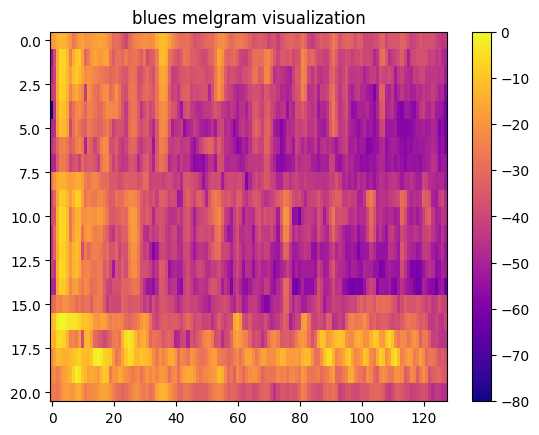

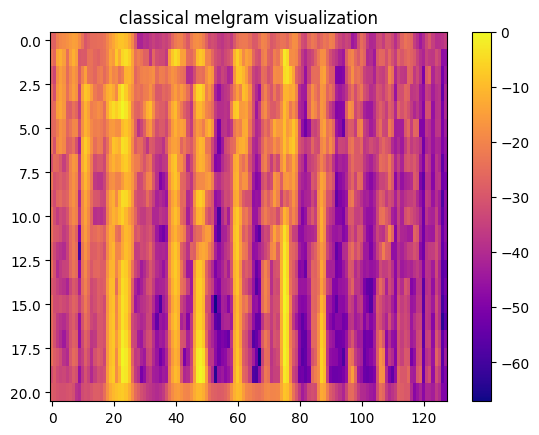

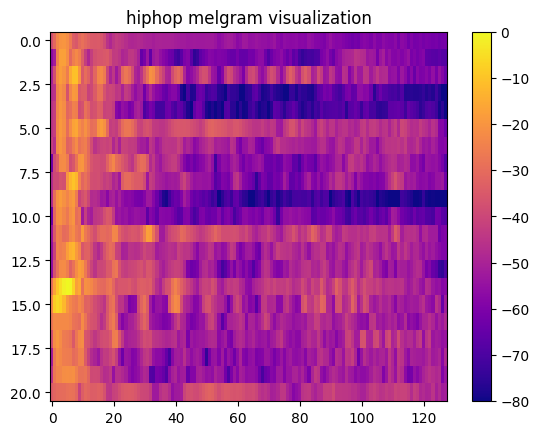

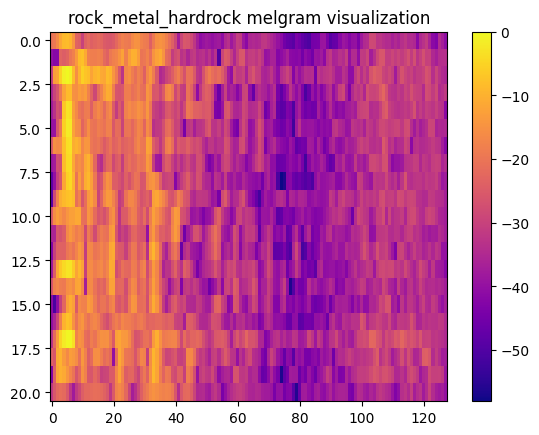

In [15]:
# Visualize a random melgram for each class
classes = np.unique(y_train)

for class_label in classes:
    all_labels = np.where(class_label == y_train)[0]
    pick = random.choice(all_labels)
    melgram, label = train_dataset[pick]

    plt.figure()
    plt.imshow(melgram, cmap='plasma', aspect='auto')
    plt.colorbar()
    plt.title(class_names[class_label] + ' melgram visualization')

## *Βήμα 2: Ορισμός Νευρωνικού Δικτύου*

In [16]:
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super(ConvolutionalNeuralNetwork, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, 5)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.conv3 = nn.Conv2d(32, 64, 5)
        self.conv4 = nn.Conv2d(64, 128, 5)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(71680, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 32)
        self.fc4 = nn.Linear(32, 4)

    def forward(self, x):
        x = torch.unsqueeze(x, 1)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)

        return x

## *Βήμα 3: Εκπαίδευση δικτύου:*

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ConvolutionalNeuralNetwork().to(device)

learning_rate = 0.002
n_epochs = 5
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), learning_rate)

test_loss, test_f1, test_accuracy, test_confusion_mx, best_model = best_model_function(n_epochs, optimizer, train_dataloader, val_dataloader, test_dataloader, loss_function, model)

Validation Epoch: 1
Training Epoch: 1
loss: 1.353219  [    0/ 3200]
loss:     nan  [  512/ 3200]
loss:     nan  [ 1024/ 3200]
loss:     nan  [ 1536/ 3200]
loss:     nan  [ 2048/ 3200]
loss:     nan  [ 2560/ 3200]
loss:     nan  [ 3072/ 3200]
Validation loss: nan
F1 score: 0.1
Accuracy: 0.25
Validation Epoch: 2
Training Epoch: 1
loss:     nan  [    0/ 3200]
loss:     nan  [  512/ 3200]
loss:     nan  [ 1024/ 3200]
loss:     nan  [ 1536/ 3200]
loss:     nan  [ 2048/ 3200]
loss:     nan  [ 2560/ 3200]
loss:     nan  [ 3072/ 3200]
Validation loss: nan
F1 score: 0.1
Accuracy: 0.25
Validation Epoch: 3
Training Epoch: 1
loss:     nan  [    0/ 3200]
loss:     nan  [  512/ 3200]
loss:     nan  [ 1024/ 3200]
loss:     nan  [ 1536/ 3200]
loss:     nan  [ 2048/ 3200]
loss:     nan  [ 2560/ 3200]
loss:     nan  [ 3072/ 3200]
Validation loss: nan
F1 score: 0.1
Accuracy: 0.25
Validation Epoch: 4
Training Epoch: 1
loss:     nan  [    0/ 3200]
loss:     nan  [  512/ 3200]
loss:     nan  [ 1024/ 3200]
l

Το δίκτυο δεν μπορεί να εκπαιδευτεί. Επιλέγουμε να μην ξεπεράσουμε τις 5 εποχές για κέρδος χρόνου, μιας και παρατηρείται άμεσα η αδυναμία εκπαίδευσης.

## *Βήμα 4: Pooling and Padding*

In [18]:
class NewConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super(NewConvolutionalNeuralNetwork, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, 5, padding=2)
        self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
        self.conv3 = nn.Conv2d(32, 64, 5, padding=2)
        self.conv4 = nn.Conv2d(64, 128, 5, padding=2)

        self.flatten = nn.Flatten()
        self.max_pool = nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(1024, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 32)
        self.fc4 = nn.Linear(32, 4)

    def forward(self, x):
        x = torch.unsqueeze(x, 1)

        x = self.conv1(x)
        x = self.max_pool(x)
        x = self.conv2(x)
        x = self.max_pool(x)
        x = self.conv3(x)
        x = self.max_pool(x)
        x = self.conv4(x)
        x = self.max_pool(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)

        return x

In [19]:
model = NewConvolutionalNeuralNetwork().to(device)

learning_rate = 0.002
n_epochs = 30
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), learning_rate)

tik = time.time()
test_loss, test_f1, test_accuracy, test_confusion_mx, best_model = best_model_function(n_epochs, optimizer, train_dataloader, val_dataloader, test_dataloader, loss_function, model)
tok = time.time() - tik
print(f'Time elapsed: {tok:>0.2f} sec')

Validation Epoch: 1
Training Epoch: 1
loss: 1.416670  [    0/ 3200]
loss: 1.374690  [  512/ 3200]
loss: 1.402249  [ 1024/ 3200]
loss: 1.307643  [ 1536/ 3200]
loss: 1.372181  [ 2048/ 3200]
loss: 1.234089  [ 2560/ 3200]
loss: 1.044681  [ 3072/ 3200]
Validation loss: 1.1851378464698792
F1 score: 0.4177345900683055
Accuracy: 0.51125
Validation Epoch: 2
Training Epoch: 1
loss: 1.146029  [    0/ 3200]
loss: 1.205777  [  512/ 3200]
loss: 1.335410  [ 1024/ 3200]
loss: 1.234087  [ 1536/ 3200]
loss: 1.205546  [ 2048/ 3200]
loss: 0.999832  [ 2560/ 3200]
loss: 0.914339  [ 3072/ 3200]
Validation loss: 1.0328587579727173
F1 score: 0.3806954227598508
Accuracy: 0.47875
Validation Epoch: 3
Training Epoch: 1
loss: 1.020662  [    0/ 3200]
loss: 0.922895  [  512/ 3200]
loss: 0.762543  [ 1024/ 3200]
loss: 1.400262  [ 1536/ 3200]
loss: 1.189466  [ 2048/ 3200]
loss: 0.909791  [ 2560/ 3200]
loss: 0.742475  [ 3072/ 3200]
Validation loss: 0.9760658800601959
F1 score: 0.6059424442862144
Accuracy: 0.60375
Validat

Με την εφαρμογή padding 2 στοιχείων στα συνελικτικά επίπεδα τα οποία ακολουθούνται από max pooling με kernel size 2, αυξάνονται οι χωρικές διαστάσεις μετά την συνέλιξη και μετά μειώνονται μετά το pooling. Έτσι διατηρούνται τα χωρικά χαρακτηριστικά ενώ μειώνεται το συνολικό μέγεθος του feature map για τα επόμενα επίπεδα. Παρατηρείται σημαντική βελτίωση στα αποτελέσματα των μετρικών, όπως επίσης και συγκριτικά μεγάλη αύξηση στον χρόνο εκτέλεσης.

## *Βήμα 5: Activation functions*

In [20]:
import torch.nn.functional as F

class NewConvolutionalNeuralNetworkReLU(nn.Module):
    def __init__(self):
        super(NewConvolutionalNeuralNetworkReLU, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, 5, padding=2)
        self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
        self.conv3 = nn.Conv2d(32, 64, 5, padding=2)
        self.conv4 = nn.Conv2d(64, 128, 5, padding=2)

        self.flatten = nn.Flatten()
        self.max_pool = nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(1024, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 32)
        self.fc4 = nn.Linear(32, 4)

    def forward(self, x):
        x = torch.unsqueeze(x, 1)

        x = self.conv1(x)
        x = F.relu(x)
        x = self.max_pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.max_pool(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.max_pool(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)

        return x

In [21]:
model = NewConvolutionalNeuralNetworkReLU().to(device)

learning_rate = 0.002
n_epochs = 30
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), learning_rate)

tik = time.time()
test_loss, test_f1, test_accuracy, test_confusion_mx, best_model = best_model_function(n_epochs, optimizer, train_dataloader, val_dataloader, test_dataloader, loss_function, model)
tok = time.time() - tik
print(f'Time elapsed: {tok:>0.2f} sec')

Validation Epoch: 1
Training Epoch: 1
loss: 1.382967  [    0/ 3200]
loss: 1.354039  [  512/ 3200]
loss: 1.363645  [ 1024/ 3200]
loss: 1.353451  [ 1536/ 3200]
loss: 1.381775  [ 2048/ 3200]
loss: 1.395190  [ 2560/ 3200]
loss: 1.321068  [ 3072/ 3200]
Validation loss: 1.3650437521934509
F1 score: 0.1
Accuracy: 0.25
Validation Epoch: 2
Training Epoch: 1
loss: 1.423988  [    0/ 3200]
loss: 1.338005  [  512/ 3200]
loss: 1.401758  [ 1024/ 3200]
loss: 1.322764  [ 1536/ 3200]
loss: 1.313498  [ 2048/ 3200]
loss: 1.334394  [ 2560/ 3200]
loss: 1.347963  [ 3072/ 3200]
Validation loss: 1.3515377235412598
F1 score: 0.16792412968265408
Accuracy: 0.2875
Validation Epoch: 3
Training Epoch: 1
loss: 1.274494  [    0/ 3200]
loss: 1.321761  [  512/ 3200]
loss: 1.338047  [ 1024/ 3200]
loss: 1.379132  [ 1536/ 3200]
loss: 1.327532  [ 2048/ 3200]
loss: 1.346705  [ 2560/ 3200]
loss: 1.287355  [ 3072/ 3200]
Validation loss: 1.3140085554122924
F1 score: 0.2905341446923597
Accuracy: 0.41625
Validation Epoch: 4
Train

Εφαρμόζοντας την συνάρτηση ενεργοποίησης ReLU, η απόδοση μειώνεται ελαφρώς.

# **Ερώτημα 3: Improving Performance**

## *Βήμα 1: Reproducibility*

In [22]:
def train_function_reproducibility(n_epochs, optimizer, dataloader, loss_function, model):
    size = len(dataloader.dataset)
    for epoch in range(n_epochs):

        # Same seed for every training epoch

        # Produce the same random numbers every time
        random.seed(0)
        np.random.seed(0)
        torch.manual_seed(0)
        # Ensure deterministic behaviour in cuDNN / Used by PyTorch
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        # If more than one GPU is used, seed them all
        torch.cuda.manual_seed_all(0)

        print(f'Training Epoch: {epoch+1}')
        ###
        for batch, (X, y) in enumerate(dataloader):
            X = X.to(device)
            y = y.to(device)

            predictions = model(X)
            loss = loss_function(predictions, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch % 32 == 0:
                loss, current = loss.item(), batch * len(X)
                print(f'loss: {loss:>7f}  [{current:>5d}/{size:>5d}]')

    return model

In [23]:
def best_model_function_reproducibility(n_epochs, optimizer, train_dataloader, val_dataloader, test_dataloader, loss_function, model):
    best_f1 = 0

    for epoch in range(n_epochs):
        print(f'Validation Epoch: {epoch+1}')
        # Use seeded train function
        train_function_reproducibility(1, optimizer, train_dataloader, loss_function, model)

        # Evaluate on validation set
        val_loss, val_f1, val_accuracy, val_confusion_mx = evaluation_function(val_dataloader, loss_function, model)

        print(f'Validation loss: {val_loss}')
        print(f'F1 score: {val_f1}')
        print(f'Accuracy: {val_accuracy}')

        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model = model
            best_epoch = epoch

    test_loss, test_f1, test_accuracy, test_confusion_mx = evaluation_function(test_dataloader, loss_function, best_model)
    print(f'\n\nModel with the best F1 metric on Test found at epoch n={best_epoch+1}')
    print(f'Test Loss: {test_loss}')
    print(f'Test F1: {test_f1}')
    print(f'Test Accuracy: {test_accuracy}')
    print('Confusion Matrix:')
    print(test_confusion_mx)

    return test_loss, test_f1, test_accuracy, test_confusion_mx, best_model

In [24]:
model = NewConvolutionalNeuralNetworkReLU().to(device)

learning_rate = 0.002
n_epochs = 30
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), learning_rate)

tik = time.time()
test_loss, test_f1, test_accuracy, test_confusion_mx, best_model = best_model_function_reproducibility(n_epochs, optimizer, train_dataloader, val_dataloader, test_dataloader, loss_function, model)
tok = time.time() - tik
print(f'Time elapsed: {tok:>0.2f} sec')

Validation Epoch: 1
Training Epoch: 1
loss: 1.388752  [    0/ 3200]
loss: 1.391025  [  512/ 3200]
loss: 1.385884  [ 1024/ 3200]
loss: 1.380589  [ 1536/ 3200]
loss: 1.384037  [ 2048/ 3200]
loss: 1.359282  [ 2560/ 3200]
loss: 1.377524  [ 3072/ 3200]
Validation loss: 1.3692994832992553
F1 score: 0.2770470664087685
Accuracy: 0.40875
Validation Epoch: 2
Training Epoch: 1
loss: 1.391134  [    0/ 3200]
loss: 1.344607  [  512/ 3200]
loss: 1.378003  [ 1024/ 3200]
loss: 1.371071  [ 1536/ 3200]
loss: 1.382596  [ 2048/ 3200]
loss: 1.309318  [ 2560/ 3200]
loss: 1.373794  [ 3072/ 3200]
Validation loss: 1.3358774256706238
F1 score: 0.26047782726972124
Accuracy: 0.39125
Validation Epoch: 3
Training Epoch: 1
loss: 1.378205  [    0/ 3200]
loss: 1.287183  [  512/ 3200]
loss: 1.360790  [ 1024/ 3200]
loss: 1.311033  [ 1536/ 3200]
loss: 1.399209  [ 2048/ 3200]
loss: 1.135235  [ 2560/ 3200]
loss: 1.378302  [ 3072/ 3200]
Validation loss: 1.2322778391838074
F1 score: 0.28299158516257306
Accuracy: 0.415
Validat

In [25]:
model = NewConvolutionalNeuralNetworkReLU().to(device)

learning_rate = 0.002
n_epochs = 30
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), learning_rate)

tik = time.time()
test_loss, test_f1, test_accuracy, test_confusion_mx, best_model = best_model_function_reproducibility(n_epochs, optimizer, train_dataloader, val_dataloader, test_dataloader, loss_function, model)
tok = time.time() - tik
print(f'Time elapsed: {tok:>0.2f} sec')

Validation Epoch: 1
Training Epoch: 1
loss: 1.409918  [    0/ 3200]
loss: 1.369362  [  512/ 3200]
loss: 1.390073  [ 1024/ 3200]
loss: 1.391760  [ 1536/ 3200]
loss: 1.370827  [ 2048/ 3200]
loss: 1.380612  [ 2560/ 3200]
loss: 1.407016  [ 3072/ 3200]
Validation loss: 1.3819226598739625
F1 score: 0.1826040104947526
Accuracy: 0.2825
Validation Epoch: 2
Training Epoch: 1
loss: 1.398993  [    0/ 3200]
loss: 1.361950  [  512/ 3200]
loss: 1.385424  [ 1024/ 3200]
loss: 1.382448  [ 1536/ 3200]
loss: 1.365683  [ 2048/ 3200]
loss: 1.364338  [ 2560/ 3200]
loss: 1.397922  [ 3072/ 3200]
Validation loss: 1.3688869953155518
F1 score: 0.21420728784652943
Accuracy: 0.32375
Validation Epoch: 3
Training Epoch: 1
loss: 1.391093  [    0/ 3200]
loss: 1.342859  [  512/ 3200]
loss: 1.375904  [ 1024/ 3200]
loss: 1.368651  [ 1536/ 3200]
loss: 1.362696  [ 2048/ 3200]
loss: 1.300613  [ 2560/ 3200]
loss: 1.375464  [ 3072/ 3200]
Validation loss: 1.3232315182685852
F1 score: 0.27247284878863826
Accuracy: 0.40625
Valida

Αν παρατηρήσουμε τα εκτυπωμένα αποτελέσματα, θα δούμε ότι τρέχοντας 2 φορές την ίδια ακριβώς διαδικασία εκπαίδευσης, πετυχαίνουμε τα ίδια αποτελέσματα.

## *Βήμα 2: Αλγόριθμοι βελτιστοποίησης:*

In [26]:
def train_function_optim_algs(n_epochs, optimizer, dataloader, loss_function, model):
    size = len(dataloader.dataset)
    for epoch in range(n_epochs):

        for batch, (X, y) in enumerate(dataloader):
            X = X.to(device)
            y = y.to(device)

            predictions = model(X)
            loss = loss_function(predictions, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Removed prints

    return model

def evaluation_function_optim_algs(dataloader, loss_function, model):
    size = len(dataloader)
    test_loss = 0

    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            predictions = model(X)
            test_loss += loss_function(predictions, y).item()

            pred_labels.extend(predictions.argmax(1).cpu().numpy())
            true_labels.extend(y.cpu().numpy())

    average_loss = test_loss / size
    f1 = f1_score(true_labels, pred_labels, average='macro')
    accuracy = accuracy_score(true_labels, pred_labels)
    confusion_mx = confusion_matrix(true_labels, pred_labels)

    return average_loss, f1, accuracy, confusion_mx

def best_model_function_optim_algs(n_epochs, optimizer, train_dataloader, val_dataloader, test_dataloader, loss_function, model):
    best_f1 = 0

    for epoch in range(n_epochs):
        train_function_optim_algs(1, optimizer, train_dataloader, loss_function, model)

        # Evaluate on validation set
        val_loss, val_f1, val_accuracy, val_confusion_mx = evaluation_function_optim_algs(val_dataloader, loss_function, model)

        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model = model
            best_epoch = epoch

    test_loss, test_f1, test_accuracy, test_confusion_mx = evaluation_function_optim_algs(test_dataloader, loss_function, best_model)
    # Removed prints

    return test_loss, test_f1, test_accuracy, test_confusion_mx, best_model

In [27]:
learning_rate = 0.002
n_epochs = 30
loss_function = nn.CrossEntropyLoss()


# Adadelta
model = NewConvolutionalNeuralNetworkReLU().to(device)
optimizer = torch.optim.Adadelta(model.parameters(), learning_rate)
# Best performance
adadelta_loss, adadelta_f1, adadelta_accuracy, adadelta_confusion_mx, adadelta_model = best_model_function_optim_algs(n_epochs, optimizer, train_dataloader, val_dataloader, test_dataloader, loss_function, model)

# Adagrad
model = NewConvolutionalNeuralNetworkReLU().to(device)
optimizer = torch.optim.Adagrad(model.parameters(), learning_rate)
# Best performance
adagrad_loss, adagrad_f1, adagrad_accuracy, adagrad_confusion_mx, adagrad_model = best_model_function_optim_algs(n_epochs, optimizer, train_dataloader, val_dataloader, test_dataloader, loss_function, model)

# Adam
model = NewConvolutionalNeuralNetworkReLU().to(device)
optimizer = torch.optim.Adam(model.parameters(), learning_rate)
# Best performance
adam_loss, adam_f1, adam_accuracy, adam_confusion_mx, adam_model = best_model_function_optim_algs(n_epochs, optimizer, train_dataloader, val_dataloader, test_dataloader, loss_function, model)

# AdamW
model = NewConvolutionalNeuralNetworkReLU().to(device)
optimizer = torch.optim.AdamW(model.parameters(), learning_rate)
# Best performance
adamw_loss, adamw_f1, adamw_accuracy, adamw_confusion_mx, adamw_model = best_model_function_optim_algs(n_epochs, optimizer, train_dataloader, val_dataloader, test_dataloader, loss_function, model)

# Adamax
model = NewConvolutionalNeuralNetworkReLU().to(device)
optimizer = torch.optim.Adamax(model.parameters(), learning_rate)
# Best performance
adamax_loss, adamax_f1, adamax_accuracy, adamax_confusion_mx, adamax_model = best_model_function_optim_algs(n_epochs, optimizer, train_dataloader, val_dataloader, test_dataloader, loss_function, model)

# ASGD
model = NewConvolutionalNeuralNetworkReLU().to(device)
optimizer = torch.optim.ASGD(model.parameters(), learning_rate)
# Best performance
asgd_loss, asgd_f1, asgd_accuracy, asgd_confusion_mx, asgd_model = best_model_function_optim_algs(n_epochs, optimizer, train_dataloader, val_dataloader, test_dataloader, loss_function, model)

# NAdam
model = NewConvolutionalNeuralNetworkReLU().to(device)
optimizer = torch.optim.NAdam(model.parameters(), learning_rate)
# Best performance
nadam_loss, nadam_f1, nadam_accuracy, nadam_confusion_mx, nadam_model = best_model_function_optim_algs(n_epochs, optimizer, train_dataloader, val_dataloader, test_dataloader, loss_function, model)

# RAdam
model = NewConvolutionalNeuralNetworkReLU().to(device)
optimizer = torch.optim.RAdam(model.parameters(), learning_rate)
# Best performance
radam_loss, radam_f1, radam_accuracy, radam_confusion_mx, radam_model = best_model_function_optim_algs(n_epochs, optimizer, train_dataloader, val_dataloader, test_dataloader, loss_function, model)

# RMSprop
model = NewConvolutionalNeuralNetworkReLU().to(device)
optimizer = torch.optim.RMSprop(model.parameters(), learning_rate)
# Best performance
rmsprop_loss, rmsprop_f1, rmsprop_accuracy, rmsprop_confusion_mx, rmsprop_model = best_model_function_optim_algs(n_epochs, optimizer, train_dataloader, val_dataloader, test_dataloader, loss_function, model)

# Rprop
model = NewConvolutionalNeuralNetworkReLU().to(device)
optimizer = torch.optim.Rprop(model.parameters(), learning_rate)
# Best performance
rprop_loss, rprop_f1, rprop_accuracy, rprop_confusion_mx, rprop_model = best_model_function_optim_algs(n_epochs, optimizer, train_dataloader, val_dataloader, test_dataloader, loss_function, model)

# SGD
model = NewConvolutionalNeuralNetworkReLU().to(device)
optimizer = torch.optim.SGD(model.parameters(), learning_rate)
# Best performance
sgd_loss, sgd_f1, sgd_accuracy, sgd_confusion_mx, sgd_model = best_model_function_optim_algs(n_epochs, optimizer, train_dataloader, val_dataloader, test_dataloader, loss_function, model)


In [28]:
import pandas as pd

data = {
    'Algorithm': ['Adadelta', 'Adagrad', 'Adam', 'AdamW', 'Adamax', 'ASGD', 'NAdam', 'RAdam', 'RMSprop', 'Rprop', 'SGD'],
    'F1 Score': [adadelta_f1, adagrad_f1, adam_f1, adamw_f1, adamax_f1, asgd_f1, nadam_f1, radam_f1, rmsprop_f1, rprop_f1, sgd_f1],
    'Accuracy': [adadelta_accuracy, adagrad_accuracy, adam_accuracy, adamw_accuracy, adamax_accuracy, asgd_accuracy, nadam_accuracy, radam_accuracy, rmsprop_accuracy, rprop_accuracy, sgd_accuracy]
}

results = pd.DataFrame(data)
results.set_index('Algorithm', inplace=True)
results = results.T
results

Algorithm,Adadelta,Adagrad,Adam,AdamW,Adamax,ASGD,NAdam,RAdam,RMSprop,Rprop,SGD
F1 Score,0.517790,0.762611,0.112394,0.628542,0.693446,0.706697,0.714909,0.679656,0.634261,0.635014,0.639462
Accuracy,0.520349,0.754360,0.289971,0.625000,0.690407,0.704942,0.711483,0.674419,0.642442,0.630814,0.638808


Αξιολογώντας τις μετρικές F1 και Accuracy βλέπουμε πως ο αλγόριθμος βελτιστοποίησης Adagrad είναι με διαφορά ο πιο αποτελεσματικός, ενώ ο Adam είναι με διαφορά ο χειρότερος.

## *Βήμα 3: Batch Normalization*

In [127]:
class NewConvolutionalNeuralNetworkReLUBatchNorm(nn.Module):
    def __init__(self):
        super(NewConvolutionalNeuralNetworkReLUBatchNorm, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, 5, padding=2)
        self.conv1_norm = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
        self.conv2_norm = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 5, padding=2)
        self.conv3_norm = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, 5, padding=2)
        self.conv4_norm = nn.BatchNorm2d(128)

        self.flatten = nn.Flatten()
        self.max_pool = nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(1024, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 32)
        self.fc4 = nn.Linear(32, 4)

    def forward(self, x):
        x = torch.unsqueeze(x, 1)

        x = self.conv1(x)
        x = self.conv1_norm(x)
        x = F.relu(x)
        x = self.max_pool(x)

        x = self.conv2(x)
        x = self.conv2_norm(x)
        x = F.relu(x)
        x = self.max_pool(x)

        x = self.conv3(x)
        x = self.conv3_norm(x)
        x = F.relu(x)
        x = self.max_pool(x)

        x = self.conv4(x)
        x = self.conv4_norm(x)
        x = F.relu(x)
        x = self.max_pool(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)

        return x

model = NewConvolutionalNeuralNetworkReLUBatchNorm().to(device)

learning_rate = 0.002
n_epochs = 30
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(model.parameters(), learning_rate)

tik = time.time()
test_loss, test_f1, test_accuracy, test_confusion_mx, best_model = best_model_function(n_epochs, optimizer, train_dataloader, val_dataloader, test_dataloader, loss_function, model)
tok = time.time() - tik
print(f'Time elapsed: {tok:>0.2f} sec')

Validation Epoch: 1
Training Epoch: 1
loss: 1.397748  [    0/ 3200]
loss: 1.249824  [  512/ 3200]
loss: 0.957948  [ 1024/ 3200]
loss: 0.637819  [ 1536/ 3200]
loss: 0.997919  [ 2048/ 3200]
loss: 0.754263  [ 2560/ 3200]
loss: 0.556263  [ 3072/ 3200]
Validation loss: 0.62079605281353
F1 score: 0.7461277943251885
Accuracy: 0.75625
Validation Epoch: 2
Training Epoch: 1
loss: 0.496848  [    0/ 3200]
loss: 0.421765  [  512/ 3200]
loss: 0.303621  [ 1024/ 3200]
loss: 0.508859  [ 1536/ 3200]
loss: 1.053107  [ 2048/ 3200]
loss: 0.405802  [ 2560/ 3200]
loss: 0.573744  [ 3072/ 3200]
Validation loss: 0.5798702281713486
F1 score: 0.7583256394424882
Accuracy: 0.7575
Validation Epoch: 3
Training Epoch: 1
loss: 0.679816  [    0/ 3200]
loss: 0.443805  [  512/ 3200]
loss: 0.365981  [ 1024/ 3200]
loss: 0.379059  [ 1536/ 3200]
loss: 0.523268  [ 2048/ 3200]
loss: 0.868409  [ 2560/ 3200]
loss: 0.625429  [ 3072/ 3200]
Validation loss: 0.5484315720200539
F1 score: 0.7944271120340124
Accuracy: 0.7925
Validation 

# **Βήμα 4: Testing**

## **YouTube_to_melgram functions**

In [51]:
# Step 1: Install the necessary libraries
!pip install pytubefix pydub

# Step 2: Import the libraries
from pytubefix import YouTube
from pydub import AudioSegment
import os

# Step 3: Download the YouTube video as an audio file
def download_youtube(youtube_url, output_path="output.wav"):
    yt = YouTube(youtube_url)
    stream = yt.streams.filter(only_audio=True).first()
    audio_file = stream.download(filename='downloaded_audio')

    # Step 4: Convert the audio file to .wav format using pydub
    audio = AudioSegment.from_file(audio_file)
    audio.export(output_path, format="wav")

    # Clean up the downloaded file
    os.remove(audio_file)

In [52]:
import os
import librosa
import numpy as np

window_length = (50 * 1e-3)
hop_length = (50 * 1e-3)
mel_time_size = 21

def load_wav(filename):
    """Read audio file and return audio signal and sampling frequency"""
    if not os.path.exists(filename):
        raise FileNotFoundError
    # Load file using librosa
    x, fs = librosa.load(filename, sr=None)
    return x, fs


def melspectrogram(x=None, fs=None, n_fft=None, hop_length=None,
                   fuse=False):
    """Returns a mel spectrogram."""

    if x is None:
        return None
    # Set some values
    if n_fft is None:
        n_fft = int(window_length * fs)
    if hop_length is None:
        hop_length = int(hop_length * fs)
    # Get spectrogram
    spectrogram = librosa.feature.melspectrogram(y=x, sr=fs, n_fft=n_fft,
                                                 hop_length=hop_length)
    # Convert to MEL-Scale
    spectrogram_dB = librosa.power_to_db(spectrogram, ref=np.max)  # (n_mel,t)

    if fuse:
        chroma = librosa.feature.chroma_stft(y=x, sr=fs, n_fft=n_fft,
                                             hop_length=hop_length)
        chroma_dB = librosa.power_to_db(chroma)
        out = np.concatenate((spectrogram_dB.T, chroma_dB.T), axis=1)
    else:
        # Transpose to return (time,n_mel)
        out = spectrogram_dB.T
    return out


def get_melgrams(file):
    signal, fs = load_wav(file)

    segment_length = int((mel_time_size - 1) * window_length * fs)
    sequence_length = signal.shape[0]
    progress = 0
    segments = []
    while progress < sequence_length:
        if progress + segment_length > sequence_length:
            fill_data = sequence_length - progress
            empty_data = segment_length - fill_data
            feature = melspectrogram(
                np.pad(signal[progress:], (0, empty_data), 'constant'),
                fs=fs, n_fft=int(window_length * fs), hop_length=int(hop_length * fs))
            segments.append(feature)
        else:
            feature = melspectrogram(
                signal[progress:progress + segment_length],
                fs=fs, n_fft=int(window_length * fs), hop_length=int(hop_length * fs))

            segments.append(feature)
        progress += segment_length

    return segments


def youtube_to_melgram(url):
    download_youtube(url)
    melgrams = get_melgrams("output.wav")
    np.save("youtube_melgrams.npy", melgrams)

## *Βήμα 1: Inference*

In [53]:
def music_recognition(dataloader, model):
    model.to(device)
    pred_labels = []

    with torch.no_grad():
        for X in dataloader:
            X = X[0].to(device)

            predictions = model(X)
            pred_labels.extend(predictions.argmax(1).cpu())

    return pred_labels

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## *Βήμα 2: Κατέβασμα μουσικής από το youtube*

In [152]:
# Classical music
youtube_to_melgram('https://www.youtube.com/watch?v=Obo4ewznBLM')
classical_melgrams = np.load('youtube_melgrams.npy')
os.remove('youtube_melgrams.npy')
os.remove('output.wav')

# Hip-Hop music
youtube_to_melgram('https://www.youtube.com/watch?v=5qm8PH4xAss')
hiphop_melgrams = np.load('youtube_melgrams.npy')
os.remove('youtube_melgrams.npy')
os.remove('output.wav')

# Rock music
youtube_to_melgram('https://www.youtube.com/watch?v=6yP1tcy9a10')
rock_melgrams = np.load('youtube_melgrams.npy')
os.remove('youtube_melgrams.npy')
os.remove('output.wav')

# Blues music
youtube_to_melgram('https://www.youtube.com/watch?v=l45f28PzfCI')
blues_melgrams = np.load('youtube_melgrams.npy')
os.remove('youtube_melgrams.npy')
os.remove('output.wav')


## *Βήμα 3: Προβλέψεις*

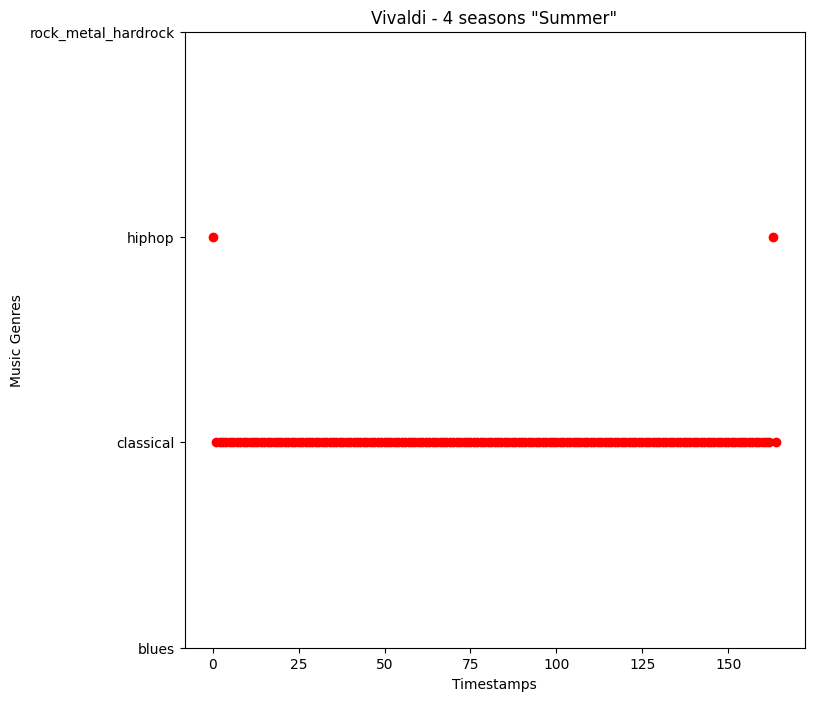

In [157]:
import matplotlib.pyplot as plt

# Convert the melgrams to a DataLoader for inference
classical_melgrams_tensor = torch.tensor(classical_melgrams)
dataset = TensorDataset(classical_melgrams_tensor)
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

classical_predictions = music_recognition(dataloader, adagrad_model)

# Plot predictions over time
timestamps = np.arange(len(classical_predictions))
plt.figure(figsize=(8, 8))
plt.scatter(timestamps, classical_predictions, c='red', label='Predicted', marker='o')
plt.yticks(range(len(class_names)), class_names)
plt.xlabel('Timestamps')
plt.ylabel('Music Genres')
plt.title('Vivaldi - 4 seasons "Summer"')
plt.show()

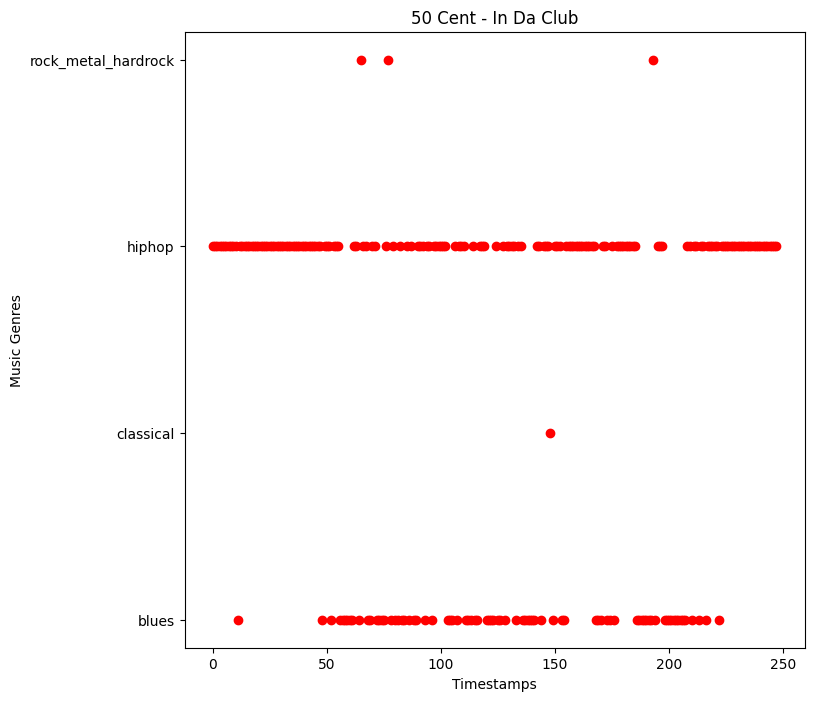

In [158]:
# Convert the melgrams to a DataLoader for inference
hiphop_melgrams_tensor = torch.tensor(hiphop_melgrams)
dataset = TensorDataset(hiphop_melgrams_tensor)
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

hiphop_predictions = music_recognition(dataloader, adagrad_model)

# Plot predictions over time
timestamps = np.arange(len(hiphop_predictions))
plt.figure(figsize=(8, 8))
plt.scatter(timestamps, hiphop_predictions, c='red', label='Predicted', marker='o')
plt.yticks(range(len(class_names)), class_names)
plt.xlabel('Timestamps')
plt.ylabel('Music Genres')
plt.title('50 Cent - In Da Club')
plt.show()

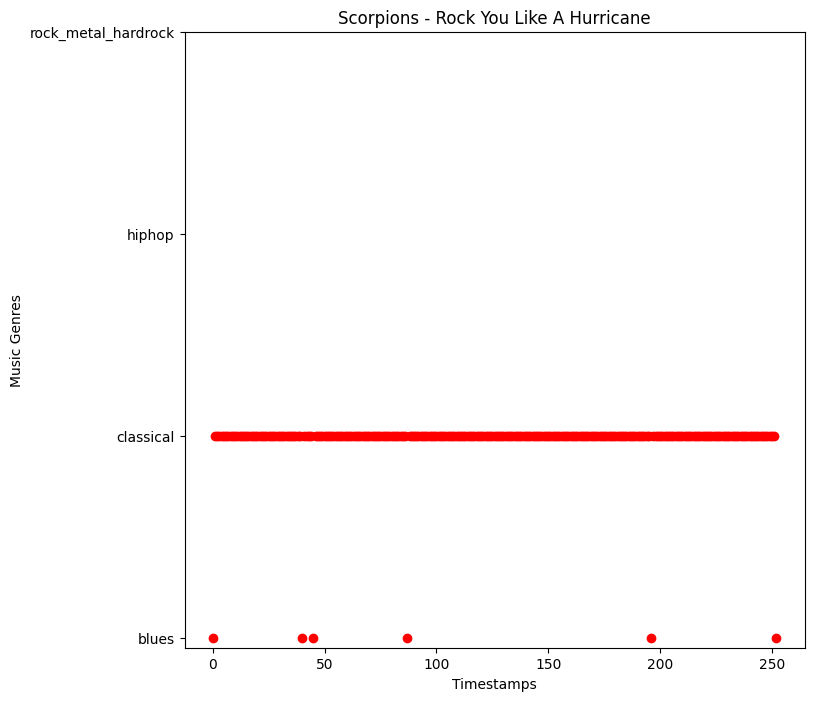

In [159]:
# Convert the melgrams to a DataLoader for inference
rock_melgrams_tensor = torch.tensor(rock_melgrams)
dataset = TensorDataset(rock_melgrams_tensor)
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

rock_predictions = music_recognition(dataloader, adagrad_model)

# Plot predictions over time
timestamps = np.arange(len(rock_predictions))
plt.figure(figsize=(8, 8))
plt.scatter(timestamps, rock_predictions, c='red', label='Predicted', marker='o')
plt.yticks(range(len(class_names)), class_names)
plt.xlabel('Timestamps')
plt.ylabel('Music Genres')
plt.title('Scorpions - Rock You Like A Hurricane')
plt.show()

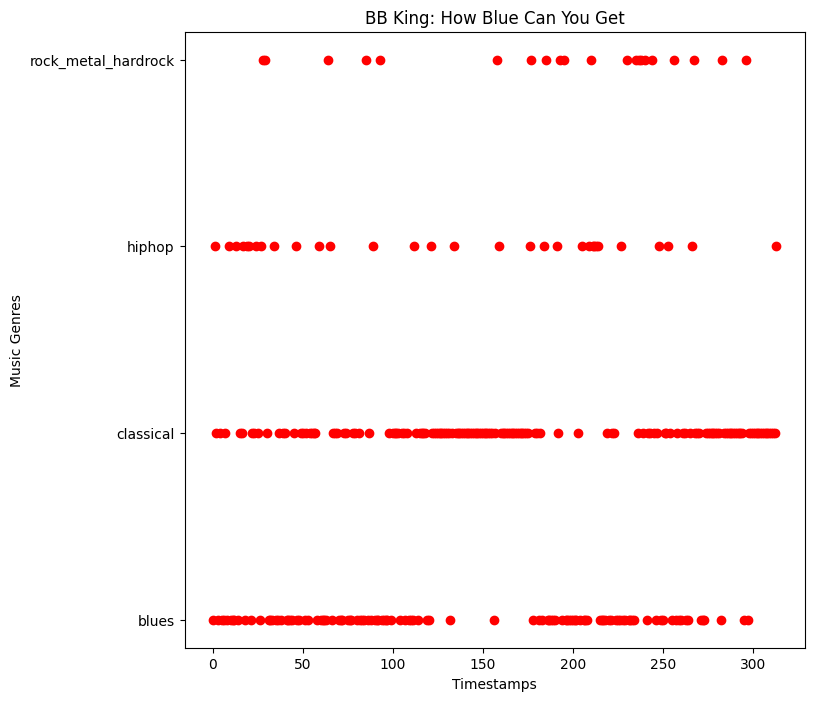

In [160]:
# Convert the melgrams to a DataLoader for inference
blues_melgrams_tensor = torch.tensor(blues_melgrams)
dataset = TensorDataset(blues_melgrams_tensor)
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

blues_predictions = music_recognition(dataloader, adagrad_model)

# Plot predictions over time
timestamps = np.arange(len(blues_predictions))
plt.figure(figsize=(8, 8))
plt.scatter(timestamps, blues_predictions, c='red', label='Predicted', marker='o')
plt.yticks(range(len(class_names)), class_names)
plt.xlabel('Timestamps')
plt.ylabel('Music Genres')
plt.title('BB King: How Blue Can You Get')
plt.show()

### *Σχολιασμός προβλέψεων*
Εφαρμόζουμε το εκπαιδευμένο με Adagrad μοντέλο, δεδομένου ότι είχε την μεγαλύτερη ακρίβεια, ωστόσο τα αποτελέσματα στο Testing δεν είναι ιδανικά. Μπορούμε να δούμε το περιθώριο βελτίωσης του μοντέλου μας με βάση τα σημεία προβλέψεων ανά είδος από τις γραφικές, ωστόσο έχουμε αξιοπρεπή αποτελέσματα. Συγκεκριμένα, φαίνεται το μοντέλο να πετυχαίνει στην πρόβλεψη των κομματιών κλασσικής και χιπ χοπ μουσικής, ενώ να αποτυγχάνει πλήρως να αναγνωρίσει την ροκ ενώ στα blues έχουμε σημαντική απώλεια.